# Histopathologic Cancer Detection

This is for the [Kaggle Competition](https://www.kaggle.com/competitions/histopathologic-cancer-detection).

The target is creating an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torchvision
import PIL
from pathlib import Path
import torchsummary
import math
import tqdm


%matplotlib inline

## Loading Data and EDA

In [3]:
labels_df = pd.read_csv('.data/train_labels.csv')
labels_df['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

In [4]:
train_image_dir = Path(".") / ".data" / "train"
f_image = next(train_image_dir.iterdir())
print("size of image: ", PIL.Image.open(f_image)._size)

whs = [
    PIL.Image.open(image_path)._size for image_path in train_image_dir.iterdir()
]
np.unique(whs)
print("All image has the same size")

size of image:  (96, 96)
All image has the same size


In [4]:
def plot_sample_imgs(samples, title):
    rows = 3
    cols = 10
    plt.subplots(rows, cols, figsize=(cols, rows))
    for i, smp in enumerate(samples[:rows * cols]):
        image_path = os.path.join(".data/train" , smp +'.tif')
        img = PIL.Image.open(image_path)
        PIL.ImageDraw.Draw(img)
        plt.subplot(rows, cols, i + 1) 
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title)

### Malignant Image Plot

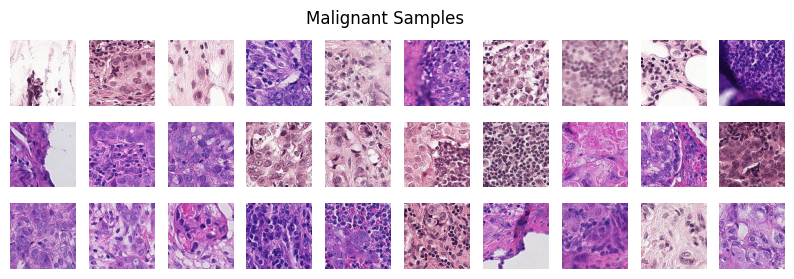

In [5]:
plot_sample_imgs(labels_df[labels_df['label']==1]['id'].values, "Malignant Samples")

### None Malignant Image Plot

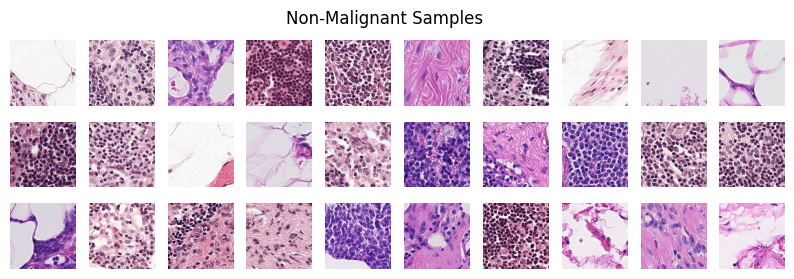

In [6]:
plot_sample_imgs(labels_df[labels_df['label']==0]['id'].values, "Non-Malignant Samples")

### Data Loaders & Data Preprocessing

In [ ]:
class CancerImageDataset(torch.utils.data.Dataset):
    def __init__(self, transform: torchvision.transforms.Compose, size: int = -1):
        self.transform = transform

        data_path = Path("./.data")
        all_image_paths = list((data_path / "train").iterdir())  
        idx_choose = np.random.choice(
            np.arange(len(all_image_paths)), 
            size,
            replace=False
        ).tolist()
        self.sample_paths: list[Path] = [all_image_paths[x] for x in idx_choose]
        
        labels_df=pd.read_csv(data_path / "train_labels.csv")
        labels_df.set_index("id", inplace=True)
        self.sample_lables = [labels_df.loc[sample_path.stem].values[0] for sample_path in self.sample_paths]
      
    def __len__(self):
        return len(self.sample_paths)
      
    def __getitem__(self, i):
        return (
            self.transform(
                PIL.Image.open(self.sample_paths[i])
            ), 
            torch.nn.functional.one_hot(torch.tensor(self.sample_lables[i]), num_classes=2).to(torch.float)
        )

In [21]:
training_augments = torchvision.transforms.Compose([
    torchvision.transforms.Resize((48, 48)),
    torchvision.transforms.RandomHorizontalFlip(p=0.3), 
    torchvision.transforms.RandomVerticalFlip(p=0.3),  
    torchvision.transforms.RandomRotation(90),
    torchvision.transforms.ToTensor()
])
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((48, 48)),
    torchvision.transforms.ToTensor(),
])

In [7]:
train_ds = CancerImageDataset(training_augments, size=3000)
val_ds = CancerImageDataset(val_transform, size=750)

print("train set has samples:", len(train_ds))
print("validation set has samples:", len(val_ds))

train set has samples: 3000
validation set has samples: 750


In [8]:
image, label = train_ds[0]
print(image.shape)
print(label)

torch.Size([3, 48, 48])
tensor([0., 1.])


In [9]:
BATCH_SIZE = 32
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE)

## Model Architecture Exploration

### NaiveCNN

In [34]:
class NaiveCNN(torch.nn.Module):
    def __init__(self, 
        input_shape: tuple[int, int, int],
        ff_hide_size: int,
        num_classes: int,
    ) -> None:
        super().__init__()
        C, W, H = input_shape

        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(C, C*2, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(C*2, C*4, kernel_size=3, padding=1, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(C*4, C*8, kernel_size=3, padding=1, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(C*8, C*16, kernel_size=3, padding=1, stride=2),
            torch.nn.ReLU(),
            torch.nn.Flatten(1, -1),
            torch.nn.LazyLinear(ff_hide_size),
            torch.nn.Dropout(.1),
            torch.nn.ReLU(),
            torch.nn.Linear(ff_hide_size, num_classes),
        )
    
    def forward(self, in_data: torch.Tensor) -> torch.Tensor:
        return self.cnn(in_data)


In [11]:
loss_function = torch.nn.CrossEntropyLoss()

In [12]:
def calculate_accuracy(model, dataloader):
    model.eval()
    total_count = 0
    correct_count = 0
    with torch.no_grad():
        for data, labels in dataloader:
            logits: torch.Tensor = model(data)
            preds = logits.argmax(dim=1)
            trues = labels.argmax(dim=1)
            correct_count += (preds == trues).sum().item()
            total_count += labels.size(0)

    return correct_count / total_count if total_count > 0 else 0.0


def training_loop(
    model: torch.nn.Module, 
    train_data: torch.utils.data.DataLoader, 
    val_data: torch.utils.data.DataLoader, 
    epoch: int,
    model_saving_path: Path,
) -> tuple[list, list]:
    train_accuracy_hist = []
    val_accuracy_hist = []
    loss_hist = []
    best_val_acc = 0

    optimizer = torch.optim.AdamW(
        [{"params": model.parameters(), "lr": 5e-4}]
    )
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    device = next(model.parameters()).device
    for ep in range(epoch):
        model.train()
        epoch_loss = 0.0
        for data, labels in train_data:
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            logits: torch.Tensor = model(data)
            loss = loss_function(logits, labels)

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(train_data)
        scheduler.step(avg_epoch_loss)

        # compute accuracies (use eval mode inside helper)
        train_acc = calculate_accuracy(model, train_data)
        val_acc = calculate_accuracy(model, val_data)
        train_accuracy_hist.append(train_acc)
        val_accuracy_hist.append(val_acc)
        loss_hist.append(avg_epoch_loss)

        print(f"Epoch {ep} summary:")
        print(f" train_accuracy={train_acc}")
        print(f" val_accuracy={val_acc}")
        print(f" epoch_loss={avg_epoch_loss}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_saving_path)

    model.eval()
    model.load_state_dict(torch.load(model_saving_path, weights_only=False))

    return model, train_accuracy_hist, val_accuracy_hist, loss_hist

In [26]:
CHECKPOINT_PATH = Path("./.checkpoint") / "naiveCNN"
CHECKPOINT_PATH.mkdir(exist_ok=True, parents=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NaiveCNN((3, 48, 48), ff_hide_size=200, num_classes=2).to(device)
torchsummary.summary(model, input_size=(3, 48, 48), device=device.type)

model, train_acc_hist, val_acc_hist, loss_hist = training_loop(
    model, 
    train_dl, 
    val_dl, 
    epoch=100, 
    model_saving_path=CHECKPOINT_PATH / "weights.pt"
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 48, 48]             168
              ReLU-2            [-1, 6, 48, 48]               0
            Conv2d-3           [-1, 12, 24, 24]             660
              ReLU-4           [-1, 12, 24, 24]               0
            Conv2d-5           [-1, 24, 12, 12]           2,616
              ReLU-6           [-1, 24, 12, 12]               0
            Conv2d-7             [-1, 48, 6, 6]          10,416
              ReLU-8             [-1, 48, 6, 6]               0
           Flatten-9                 [-1, 1728]               0
           Linear-10                  [-1, 200]         345,800
          Dropout-11                  [-1, 200]               0
             ReLU-12                  [-1, 200]               0
           Linear-13                    [-1, 2]             402
Total params: 360,062
Trainable params:

Text(0, 0.5, 'Training Loss')

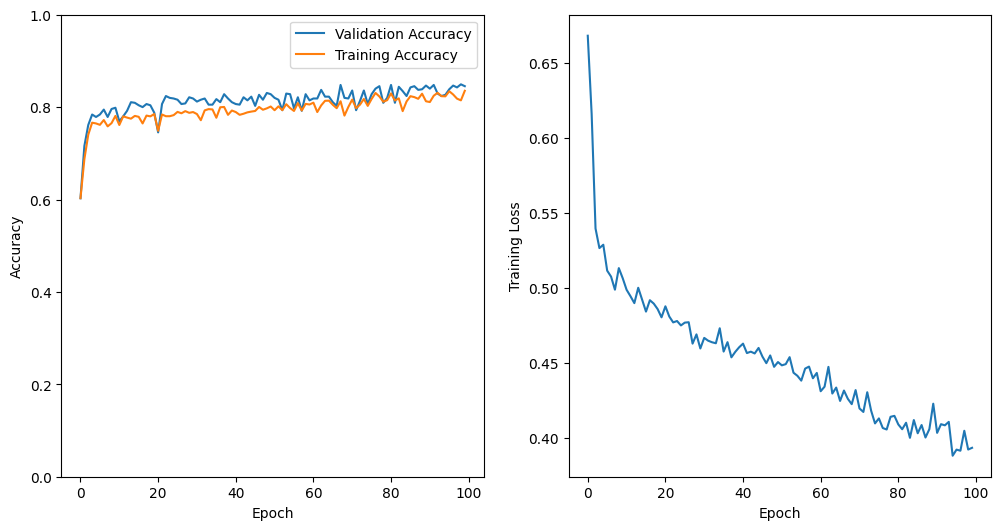

In [27]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].plot(range(0, len(val_acc_hist)), val_acc_hist, label="Validation Accuracy")
axes[0].plot(range(0, len(train_acc_hist)), train_acc_hist, label="Training Accuracy")

axes[1].plot(range(0, len(loss_hist)), loss_hist, label="Training Loss")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(0, 1)
axes[0].legend()

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Training Loss")

### CNN With Residual Layer

In [19]:
class CNNWithResidual(torch.nn.Module):
    def __init__(self, 
        input_shape: tuple[int, int, int],
        ff_hide_size: int,
        num_classes: int,
    ) -> None:
        super().__init__()
        C, W, H = input_shape

        self.cnn1 = torch.nn.Sequential(
            torch.nn.Conv2d(C, C*2, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(C*2, C*2, kernel_size=3, padding=1),
            torch.nn.ReLU(),
        )
        self.cnn2 = torch.nn.Sequential(
            torch.nn.Conv2d(C*2 + C, C*4, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(C*4, C*4, kernel_size=3, padding=1),
            torch.nn.ReLU(),
        )
        self.cnn3 = torch.nn.Sequential(
            torch.nn.Conv2d(C*4 + C*2 + C, C*8, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(C*8, C*8, kernel_size=3, padding=1),
            torch.nn.ReLU(),
        )
        self.cnn4 = torch.nn.Sequential(
            torch.nn.Conv2d(C*8 + C*4 + C*2 + C, C*16, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(C*16, C*16, kernel_size=3, padding=1),
            torch.nn.ReLU(),
        )

        self.inference_head = torch.nn.Sequential(
            torch.nn.Flatten(1, -1),
            torch.nn.LazyLinear(ff_hide_size),
            torch.nn.Dropout(.1),
            torch.nn.ReLU(),
            torch.nn.Linear(ff_hide_size, num_classes),
        )
    
    def forward(self, in_data: torch.Tensor) -> torch.Tensor:
        hid: torch.Tensor = in_data
        mean_pool = torch.nn.AvgPool2d(2)

        hid = torch.cat((hid, self.cnn1(hid)), dim=1)
        hid = mean_pool(hid)
        hid = torch.cat((hid, self.cnn2(hid)), dim=1)
        hid = mean_pool(hid)
        hid = torch.cat((hid, self.cnn3(hid)), dim=1)
        hid = mean_pool(hid)
        hid = torch.cat((hid, self.cnn4(hid)), dim=1)
        hid = mean_pool(hid)

        return self.inference_head(hid)

In [16]:
CHECKPOINT_PATH = Path("./.checkpoint") / "CNNWithResidual"
CHECKPOINT_PATH.mkdir(exist_ok=True, parents=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNWithResidual((3, 48, 48), ff_hide_size=200, num_classes=2).to(device)
torchsummary.summary(model, input_size=(3,48,48), device=device.type)

model, train_acc_hist, val_acc_hist, loss_hist = training_loop(
    model, 
    train_dl, 
    val_dl, 
    epoch=100, 
    model_saving_path=CHECKPOINT_PATH / "weights.pt"
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 48, 48]             168
              ReLU-2            [-1, 6, 48, 48]               0
            Conv2d-3            [-1, 6, 48, 48]             330
              ReLU-4            [-1, 6, 48, 48]               0
            Conv2d-5           [-1, 12, 24, 24]             984
              ReLU-6           [-1, 12, 24, 24]               0
            Conv2d-7           [-1, 12, 24, 24]           1,308
              ReLU-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 24, 12, 12]           4,560
             ReLU-10           [-1, 24, 12, 12]               0
           Conv2d-11           [-1, 24, 12, 12]           5,208
             ReLU-12           [-1, 24, 12, 12]               0
           Conv2d-13             [-1, 48, 6, 6]          19,488
             ReLU-14             [-1, 4

/home/zain_chen/cu-mscs/machine-learning/histopathologic-cancer-detection/.venv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0 summary:
 train_accuracy=0.579
 val_accuracy=0.6
 epoch_loss=0.675792468989149
Epoch 1 summary:
 train_accuracy=0.5883333333333334
 val_accuracy=0.604
 epoch_loss=0.6372988626677939
Epoch 2 summary:
 train_accuracy=0.6736666666666666
 val_accuracy=0.6733333333333333
 epoch_loss=0.6136366867638648
Epoch 3 summary:
 train_accuracy=0.6803333333333333
 val_accuracy=0.7173333333333334
 epoch_loss=0.5580164828199021
Epoch 4 summary:
 train_accuracy=0.7416666666666667
 val_accuracy=0.7933333333333333
 epoch_loss=0.5499998572024893
Epoch 5 summary:
 train_accuracy=0.752
 val_accuracy=0.768
 epoch_loss=0.5257077096624577
Epoch 6 summary:
 train_accuracy=0.74
 val_accuracy=0.7893333333333333
 epoch_loss=0.5293938859980157
Epoch 7 summary:
 train_accuracy=0.753
 val_accuracy=0.7826666666666666
 epoch_loss=0.5088480653915
Epoch 8 summary:
 train_accuracy=0.7126666666666667
 val_accuracy=0.74
 epoch_loss=0.5300673915350691
Epoch 9 summary:
 train_accuracy=0.7573333333333333
 val_accuracy=0.

Text(0, 0.5, 'Training Loss')

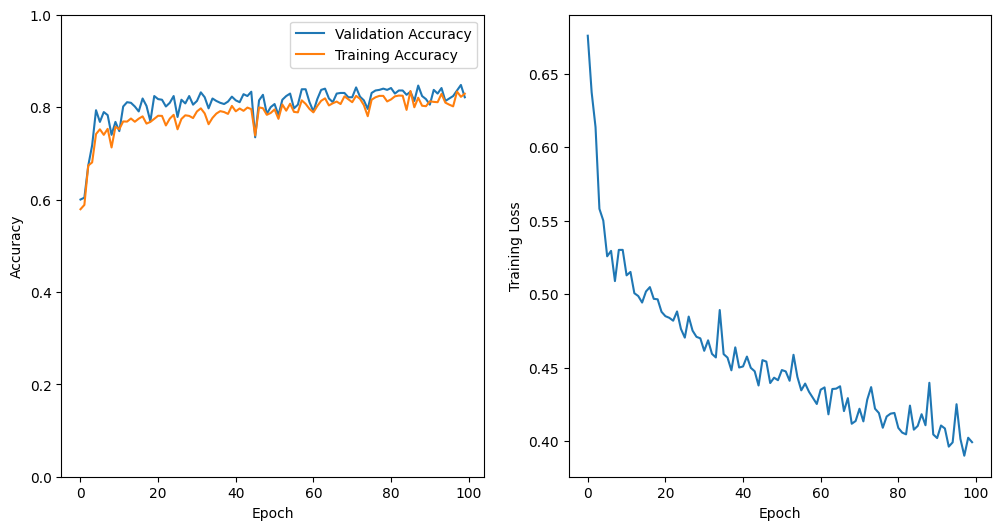

In [17]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].plot(range(0, len(val_acc_hist)), val_acc_hist, label="Validation Accuracy")
axes[0].plot(range(0, len(train_acc_hist)), train_acc_hist, label="Training Accuracy")

axes[1].plot(range(0, len(loss_hist)), loss_hist, label="Training Loss")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(0, 1)
axes[0].legend()

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Training Loss")

### Architecture Selection

Actually the two model do not have much big difference in terms of accuracy, but the Naive one do save some computation resources.

Lets go ahead use the Naive model for final model. To save my laptop some more life. I would use 30000 of the training sample for this final model training, instead of all.

In [31]:
all_train_ds = CancerImageDataset(training_augments, size=30000)
all_val_ds = CancerImageDataset(val_transform, size=3000)

BATCH_SIZE = 32
all_train_dl = torch.utils.data.DataLoader(all_train_ds, batch_size=BATCH_SIZE, shuffle=True)
all_val_dl = torch.utils.data.DataLoader(all_val_ds, batch_size=BATCH_SIZE)

In [36]:
CHECKPOINT_PATH = Path("./.checkpoint") / "Final"
CHECKPOINT_PATH.mkdir(exist_ok=True, parents=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NaiveCNN((3, 48, 48), ff_hide_size=200, num_classes=2).to(device)
torchsummary.summary(model, input_size=(3,48,48), device=device.type)

model, train_acc_hist, val_acc_hist, loss_hist = training_loop(
    model, 
    all_train_dl, 
    all_val_dl, 
    epoch=50, 
    model_saving_path=CHECKPOINT_PATH / "weights.pt"
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 48, 48]             168
              ReLU-2            [-1, 6, 48, 48]               0
            Conv2d-3           [-1, 12, 24, 24]             660
              ReLU-4           [-1, 12, 24, 24]               0
            Conv2d-5           [-1, 24, 12, 12]           2,616
              ReLU-6           [-1, 24, 12, 12]               0
            Conv2d-7             [-1, 48, 6, 6]          10,416
              ReLU-8             [-1, 48, 6, 6]               0
           Flatten-9                 [-1, 1728]               0
           Linear-10                  [-1, 200]         345,800
          Dropout-11                  [-1, 200]               0
             ReLU-12                  [-1, 200]               0
           Linear-13                    [-1, 2]             402
Total params: 360,062
Trainable params:

In [37]:
def predict_test_data(model):
    test_image_dir = Path(".") / ".data" / "test"
    submission_path = Path("my_submission.csv")

    with submission_path.open('w') as file:
        file.writelines("id,label\n")
        for img in test_image_dir.iterdir():
            img_ts = val_transform(PIL.Image.open(img))

            logits: torch.Tensor = model(img_ts.unsqueeze(0))
            label = logits.argmax(dim=1)[0]
            file.write(f"{img.stem},{label}\n")
    

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNWithResidual((3, 48, 48), ff_hide_size=200, num_classes=2).to(device)
model.load_state_dict(torch.load(Path("./.checkpoint") / "CNNWithResidual" / "weights.pt", weights_only=False))
predict_test_data(model)